In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()

from google.colab import files 
## Upload 'icu_data.csv' 
files.upload();

In [22]:
df = pd.read_csv("icu_data.csv")
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Columns: 175 entries, Unnamed: 0 to mort180
dtypes: float64(159), int64(10), object(6)
memory usage: 1.3+ MB
None


,Unnamed: 0,age,gender,height,weight,bsa,diabetes_sics,hypertension,previousmi,previousrenalfailure,confirmedinfection,gcs_d1,gcs_d2,gcs_d3,gcs_d4,gcs_d5,gcs_d6,gcs_d7,pao2_d1,pao2_d2,pao2_d3,pao2_d4,pao2_d5,pao2_d6,pao2_d7,fio2_d1,fio2_d2,fio2_d3,fio2_d4,fio2_d5,fio2_d6,fio2_d7,mech_vent_d3,mech_vent_d4,mech_vent_d5,mech_vent_d6,mech_vent_d7,special_vent_method_d1,special_vent_method_d2,special_vent_method_d3,...,bili_d2_SOFA,bili_d3_SOFA,bili_d4_SOFA,bili_d5_SOFA,bili_d6_SOFA,bili_d7_SOFA,cv_d1_SOFA,cv_d2_SOFA,cv_d3_SOFA,cv_d4_SOFA,cv_d5_SOFA,cv_d6_SOFA,cv_d7_SOFA,gcs_d1_sofa,gcs_d2_sofa,gcs_d3_sofa,gcs_d4_sofa,gcs_d5_sofa,gcs_d6_sofa,gcs_d7_sofa,creat_d1_SOFA,creat_d2_SOFA,creat_d3_SOFA,creat_d4_SOFA,creat_d5_SOFA,creat_d6_SOFA,creat_d7_SOFA,tot_d1_SOFA,tot_d2_SOFA,tot_d3_SOFA,tot_d4_SOFA,tot_d5_SOFA,tot_d6_SOFA,tot_d7_SOFA,max_SOFA,mort_icu,mort7,mort30,mort90,mort180
count,1010.000000,1010.000000,1010.000000,973.000000,1010.000000,973.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,958.000000,912.000000,624.000000,430.000000,326.000000,262.000000,215.000000,937.000000,890.000000,605.000000,417.000000,310.000000,258.000000,215.000000,958.000000,913.000000,628.000000,431.000000,325.000000,267.000000,219.000000,627.000000,431.000000,326.000000,268.000000,219.000000,957.000000,908.000000,626.000000,...,977.000000,981.000000,984.000000,885.000000,548.000000,370.000000,939.000000,904.000000,622.000000,423.000000,321.000000,267.000000,218.000000,994.000000,915.000000,625.000000,431.000000,328.000000,264.000000,216.000000,964.000000,921.000000,630.000000,435.000000,329.000000,273.000000,228.000000,810.000000,829.000000,567.000000,391.000000,289.000000,215.000000,173.000000,916.000000,1010.000000,1009.000000,1000.000000,999.000000,999.000000
mean,504.500000,60.628713,1.623762,175.591675,81.247921,1.963015,1.188119,1.305941,1.129703,1.091089,1.192079,12.370564,12.953947,13.081731,12.946512,12.978528,12.736641,12.818605,14.778015,11.680787,9.430413,8.412950,11.367742,11.296899,11.232093,43.772443,35.427163,35.507962,36.877030,37.313846,37.018727,37.762557,0.440191,0.519722,0.552147,0.541045,0.584475,1.003135,1.006608,1.004792,...,0.257932,0.219164,0.222561,0.210169,0.262774,0.243243,1.826411,1.724558,1.631833,1.678487,1.573209,1.543071,1.573394,0.382294,0.363934,0.409600,0.503480,0.500000,0.655303,0.652778,0.475104,0.599349,0.631746,0.572414,0.592705,0.538462,0.530702,4.895062,5.156815,5.370370,5.557545,5.332180,5.358140,5.583815,6.271834,1.163366,1.133796,1.220000,0.263263,0.286286
std,291.706188,15.443422,0.484681,9.974955,17.942156,0.229557,0.391001,0.461033,0.336143,0.287878,0.394130,4.234191,3.753676,3.494741,3.507491,3.525228,3.463454,3.377998,7.589030,5.103963,41.212662,49.572438,4.068013,5.014034,3.777484,20.294447,15.642575,14.186217,15.028383,15.636100,15.759340,14.297246,0.496806,0.500192,0.498038,0.499245,0.493941,0.055931,0.093683,0.089314,...,0.676752,0.646718,0.650736,0.638958,0.720756,0.690838,1.353628,1.291601,1.233385,1.239433,1.181273,1.163762,1.166597,1.022766,0.949381,1.005707,1.145004,1.162619,1.298775,1.251898,0.805229,0.958463,1.013867,0.974879,1.029182,0.973634,0.940487,2.711072,2.849615,2.790767,2.904663,2.770198,2.757677,3.005842,2.999328,0.369883,0.340602,0.414454,0.440625,0.452251
min,0.000000,18.000000,1.000000,125.000000,41.000000,1.317000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.700000,2.900000,-999.900000,-999.900000,3.300000,4.400000,4.500000,21.000000,21.000000,0.000000,0.000000,20.000000,21.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.

In [23]:
to_remove = ["Unnamed: 0"]
for var in df.columns:
    if var.find('_d') > -1 and var.find('_d1') == -1:
        to_remove.append(var)
df = df.drop( columns = to_remove )

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     1010 non-null   int64  
 1   gender                  1010 non-null   int64  
 2   height                  973 non-null    float64
 3   weight                  1010 non-null   float64
 4   bsa                     973 non-null    float64
 5   diabetes_sics           1010 non-null   int64  
 6   hypertension            1010 non-null   int64  
 7   previousmi              1010 non-null   int64  
 8   previousrenalfailure    1010 non-null   int64  
 9   confirmedinfection      1010 non-null   int64  
 10  gcs_d1                  958 non-null    float64
 11  pao2_d1                 937 non-null    float64
 12  fio2_d1                 958 non-null    float64
 13  mech_vent_d1            958 non-null    object 
 14  special_vent_method_d1  957 non-null    

In [25]:
df = df.drop("uo_d1", axis=1)

In [26]:
## separate outcomes from independent variables
outcomevars = ["mort_icu","mort7","mort30","mort90","mort180","max_SOFA"]
dfout = df[ outcomevars ]
df = df.drop( columns = outcomevars )

In [27]:
X = df
y = dfout["mort7"]

from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X, y)

ValueError: ignored

In [28]:
## set NIV values in mech_vent_d1 to nan, and convert to int64
df.loc[ df["mech_vent_d1"] == "NIV", "mech_vent_d1"] = np.nan
df["mech_vent_d1"] = df["mech_vent_d1"].astype('float')

X = df

model.fit(X,y)

ValueError: ignored

In [29]:
X = X[ np.isfinite(y) ]
y = y[ np.isfinite(y) ]

model.fit(X,y)

ValueError: ignored

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

imp = SimpleImputer(missing_values=np.nan, strategy='median')

model = LogisticRegression(C=1, solver='saga', penalty='l2', max_iter=10000)

pipe = Pipeline([('imputation', imp), ('model', model)])

X = X[ np.isfinite(y) ]  ## Remove records where the target variable is missing
y = y[ np.isfinite(y) ]

pipe.fit(X, y)

Pipeline(steps=[('imputation', SimpleImputer(strategy='median')),
                ('model',
                 LogisticRegression(C=1, max_iter=10000, penalty='l1',
                                    solver='saga'))])

In [31]:
pipe[-1].coef_

array([[ 4.54953358e-02, -1.90377645e-02, -1.27300415e-02,
        -5.88733406e-03,  0.00000000e+00, -1.56001371e-06,
        -1.03977268e-02,  4.40136410e-02,  0.00000000e+00,
         8.60375023e-02, -1.63878254e-01, -3.81428885e-03,
         1.19244731e-02, -2.55158977e-02,  0.00000000e+00,
        -2.82146524e-03,  8.97775349e-03, -1.85945226e-02,
         1.76047965e-04, -2.72792453e-04,  6.38908058e-03,
         1.69969442e-03,  1.21392005e-02, -1.17106929e-03,
        -1.44590983e-02,  1.05154137e-01,  1.52975393e-02,
        -1.42733815e-02, -7.57286957e-02,  6.97100144e-02,
         4.20959053e-02]])

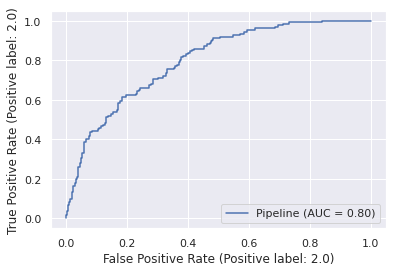

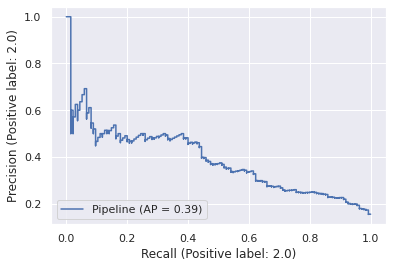

In [32]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.model_selection import cross_val_score

RocCurveDisplay.from_estimator(pipe, X, y)

PrecisionRecallDisplay.from_estimator(pipe, X, y)

In [35]:
scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print("%0.2f AUC with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.76 AUC with a standard deviation of 0.03


In [36]:
pipe.predict_proba(X)

array([[0.97530286, 0.02469714],
       [0.84149518, 0.15850482],
       [0.99257016, 0.00742984],
       ...,
       [0.89646635, 0.10353365],
       [0.96821368, 0.03178632],
       [0.84517544, 0.15482456]])

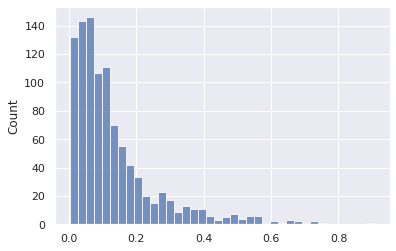

In [37]:
sns.histplot( pipe.predict_proba(X)[:,1])

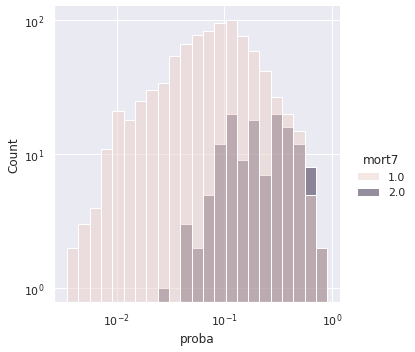

In [38]:
df_plot = pd.DataFrame( {"proba": pipe.predict_proba(X)[:,1], "mort7": y})
sns.displot( df_plot, x="proba", hue="mort7", log_scale = (True, True))